# Predicting Newsletter Subscription Using Player Behaviour and Demographics  

**Yake Zhang**  

link to the github page for this project  
https://github.com/zhangyake-123/DSCI_project_Nick.git

---

## Introduction

Player retention and community engagement are key to long-term success in online games. One measurable indicator of engagement is whether a player subscribes to the game’s newsletter. In this project, I ask:  

#### Can experience level, total gameplay time, and session behavior (frequency, duration, night/weekend activity) predict newsletter subscription? Additionally, how do player age and gender differ between subscribers and non-subscribers?

## Data Description  

I used two datasets:  
	•	players.csv (196 observations): experience level, play hours, subscription status, gender, and age.  
	•	sessions.csv (1535 observations): session start and end times per player.  

These were joined by hashedEmail to summarize per-player session features:  
	•	n_sessions: number of sessions  
	•	avg_duration: average session duration (mins)  
	•	prop_night: proportion of night sessions (10 PM–6 AM)  
	•	prop_weekend: proportion of weekend sessions (Saturday/Sunday)  

Some players had no sessions; for them, session features were filled as 0. Two players had missing ages.  

## Methods & Results

I used logistic regression to predict subscription (Subscribed vs Not Subscribed) from the following features:  
	•	experience  
    •	played_hours  
    •	n_sessions  
    •	avg_duration  
    •	prop_night  
    •	prop_weekend  
    
### Data Processing

In [50]:
library(tidyverse)
library(tidymodels)
library(lubridate)
library(ggplot2)
library(cowplot)

players <- read_csv("https://raw.githubusercontent.com/zhangyake-123/DSCI_project_Nick/refs/heads/main/players.csv")
sessions <- read_csv("https://raw.githubusercontent.com/zhangyake-123/DSCI_project_Nick/refs/heads/main/sessions.csv")
players <- players %>%
  mutate(hashedEmail = str_sub(hashedEmail, 1, 10))
sessions <- sessions %>%
  mutate(hashedEmail = str_sub(hashedEmail, 1, 10))
head(players)
head(sessions)



Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996,0.0,Adrian,Female,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


In [51]:
sessions <- sessions %>%
  mutate(
    start_dt = dmy_hm(start_time),
    end_dt   = dmy_hm(end_time),
    duration_mins = as.numeric(difftime(end_dt, start_dt, units = "mins")),
    hour = hour(start_dt),
    wday = wday(start_dt, label = TRUE),
    night = if_else(hour >= 20 | hour < 6, 1, 0),
    weekend = if_else(wday %in% c("Sat", "Sun"), 1, 0)
  )

session_features <- sessions %>%
  group_by(hashedEmail) %>%
  summarize(
    n_sessions = n(),
    avg_duration = mean(duration_mins, na.rm = TRUE),
    prop_night = mean(night, na.rm = TRUE),
    prop_weekend = mean(weekend, na.rm = TRUE),
    .groups = "drop"
  )
session_features <- session_features %>%
  mutate(hashedEmail = str_sub(hashedEmail, 1, 10))
head(session_features)

hashedEmail,n_sessions,avg_duration,prop_night,prop_weekend
<chr>,<int>,<dbl>,<dbl>,<dbl>
0088b5e134,2,53.00000,1.0000000,0.0000000
060aca80f8,1,30.00000,1.0000000,0.0000000
0ce7bfa910,1,11.00000,1.0000000,0.0000000
0d4d71be33,13,32.15385,0.6923077,0.4615385
0d70dd9cac,2,35.00000,0.5000000,0.5000000
11006065e9,1,10.00000,0.0000000,1.0000000


In [52]:
modeling_data <- players %>%
  left_join(session_features, by = "hashedEmail") %>%
  replace_na(list(n_sessions = 0, avg_duration = 0, 
                  prop_night = 0, prop_weekend = 0)) %>%
  mutate(subscribe = if_else(subscribe, "Subscribed", "Not Subscribed") %>% 
                     factor(levels = c("Not Subscribed", "Subscribed")),
         experience = factor(experience, 
                             levels = c("Beginner", "Amateur", "Regular", 
                                        "Veteran", "Pro"),
                             ordered = FALSE)) %>%
  select(-hashedEmail, -name)

glimpse(modeling_data)

Rows: 196
Columns: 9
$ experience   <fct> Pro, Veteran, Veteran, Amateur, Regular, Amateur, Regular…
$ subscribe    <fct> Subscribed, Subscribed, Not Subscribed, Subscribed, Subsc…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 17, 22, 23, 17, 25, 22, 17…
$ n_sessions   <int> 27, 3, 1, 1, 1, 0, 0, 1, 1, 0, 3, 0, 1, 1, 0, 0, 0, 37, 2…
$ avg_duration <dbl> 74.77778, 85.00000, 5.00000, 50.00000, 9.00000, 0.00000, …
$ prop_night   <dbl> 0.8518519, 1.0000000, 1.0000000, 1.0000000, 1.0000000, 0.…
$ prop_weekend <dbl> 0.5555556, 0.0000000, 0.0000000, 1.0000000, 0.0000000, 0.…


### Splitting & Modeling

In [53]:
set.seed(123)
data_split <- initial_split(modeling_data, prop = 0.75, strata = subscribe)
train_data <- training(data_split)
test_data  <- testing(data_split)

In [54]:
subscription_recipe <- recipe(subscribe ~ experience + played_hours + n_sessions + 
                                avg_duration + prop_night + prop_weekend, 
                              data = train_data)%>%
  step_mutate(subscribe = factor(subscribe, levels = c("Not Subscribed", "Subscribed")))

logistic_spec <- logistic_reg() %>%
  set_engine("glm") %>%
  set_mode("classification")

subscription_workflow <- workflow() %>%
  add_recipe(subscription_recipe) %>%
  add_model(logistic_spec)

subscription_recipe
logistic_spec



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 6



── Operations 

• Variable mutation for: factor(subscribe, levels = c("Not Subscribed",
  "Subscribed"))



Logistic Regression Model Specification (classification)

Computational engine: glm 


In [55]:
set.seed(123)
cv_folds <- vfold_cv(train_data, v = 5, strata = subscribe)

cv_results <- fit_resamples(
  subscription_workflow,
  resamples = cv_folds,
  metrics = metric_set(accuracy, roc_auc),
  control = control_resamples(save_pred = TRUE)
)

cv_metrics <- collect_metrics(cv_results)
cv_metrics

→ A | warning: glm.fit: fitted probabilities numerically 0 or 1 occurred

There were issues with some computations   A: x1

There were issues with some computations   A: x5





.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.7210181,5,0.006325144,Preprocessor1_Model1
roc_auc,binary,0.4641543,5,0.021288113,Preprocessor1_Model1


### Performance

In [56]:
final_results <- last_fit(subscription_workflow, split = data_split, 
                          metrics = metric_set(accuracy, roc_auc))

test_metrics <- collect_metrics(final_results)
test_metrics

→ A | warning: glm.fit: fitted probabilities numerically 0 or 1 occurred



.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.7346939,Preprocessor1_Model1
roc_auc,binary,0.4433761,Preprocessor1_Model1


### Visualizations

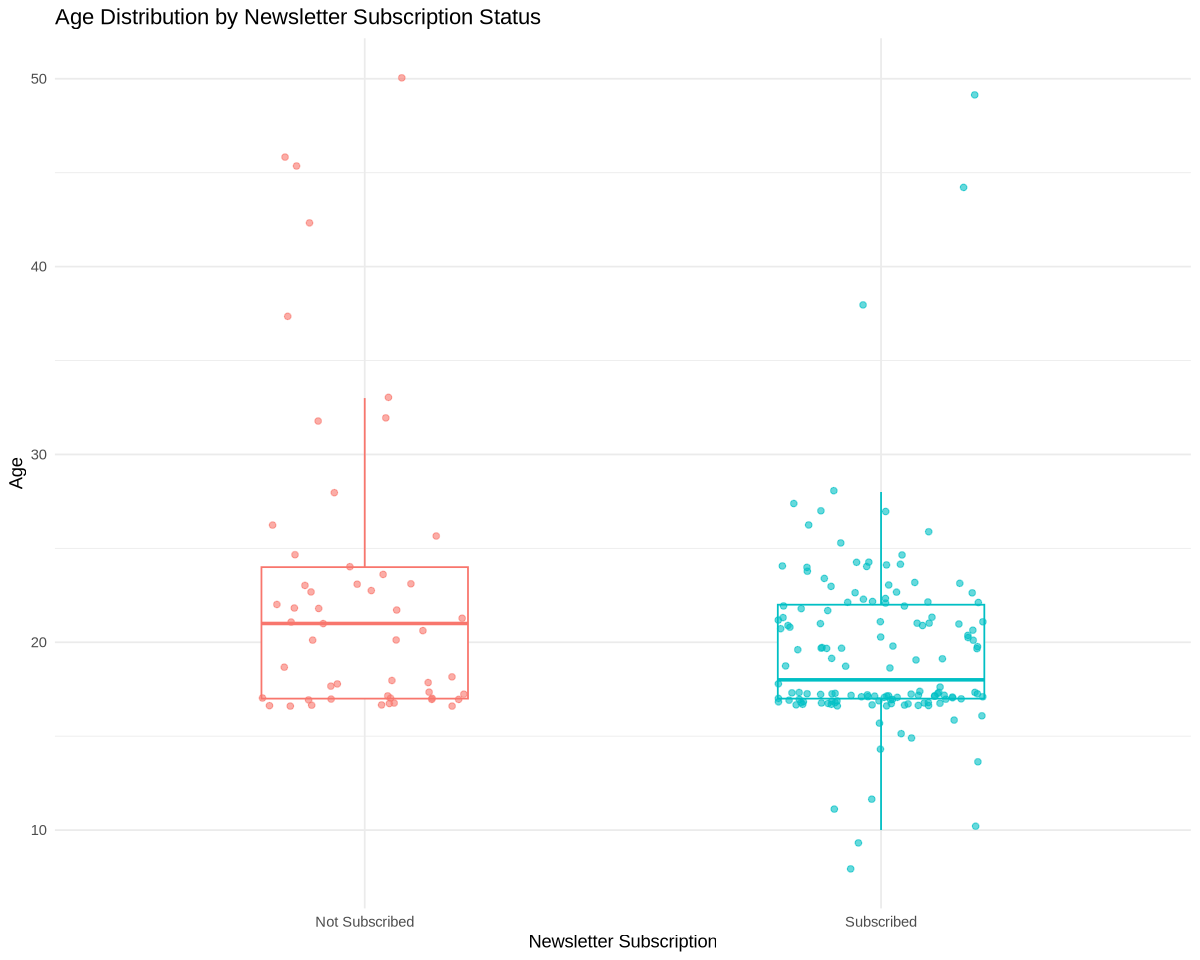

In [57]:
ggplot(modeling_data, aes(x = subscribe, y = Age, color = subscribe)) +
  geom_boxplot(width = 0.4, outlier.shape = NA, na.rm = TRUE) +
  geom_jitter(alpha = 0.6, width = 0.2, na.rm = TRUE) +
  labs(title = "Age Distribution by Newsletter Subscription Status",
       x = "Newsletter Subscription", y = "Age") +
  theme_minimal() +
  theme(legend.position = "none")

Subscribers tend to be younger, with most clustered between ages 15–20. Non-subscribers show more variation and include older players, including some over 40. This confirms age is a distinguishing factor between the two groups.

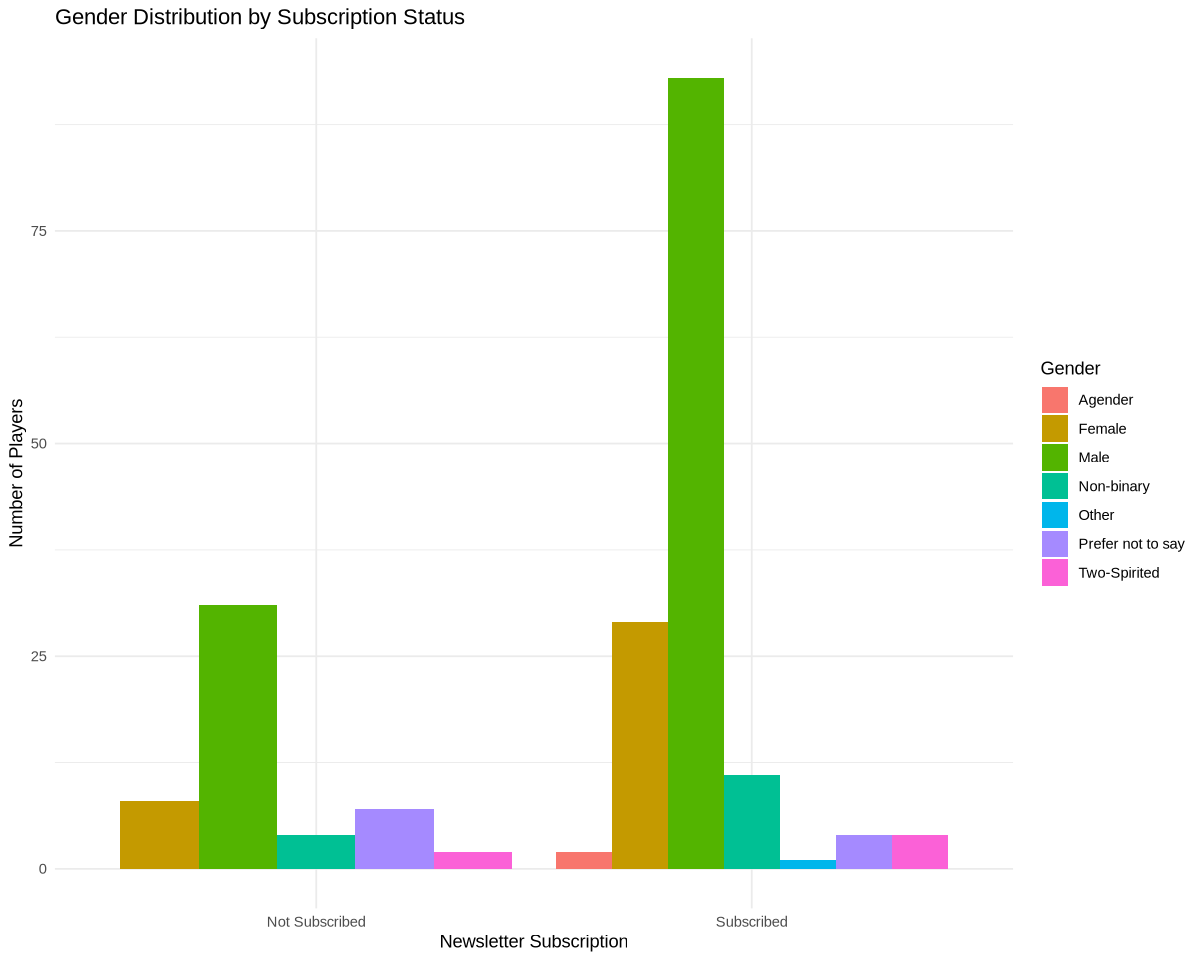

In [58]:
ggplot(modeling_data, aes(x = subscribe, fill = gender)) +
  geom_bar(position = "dodge") +
  labs(title = "Gender Distribution by Subscription Status",
       x = "Newsletter Subscription", y = "Number of Players", fill = "Gender") +
  theme_minimal()

Both groups are predominantly male. However, the proportion of female players is slightly higher among subscribers, suggesting females may be marginally more likely to engage via newsletter.

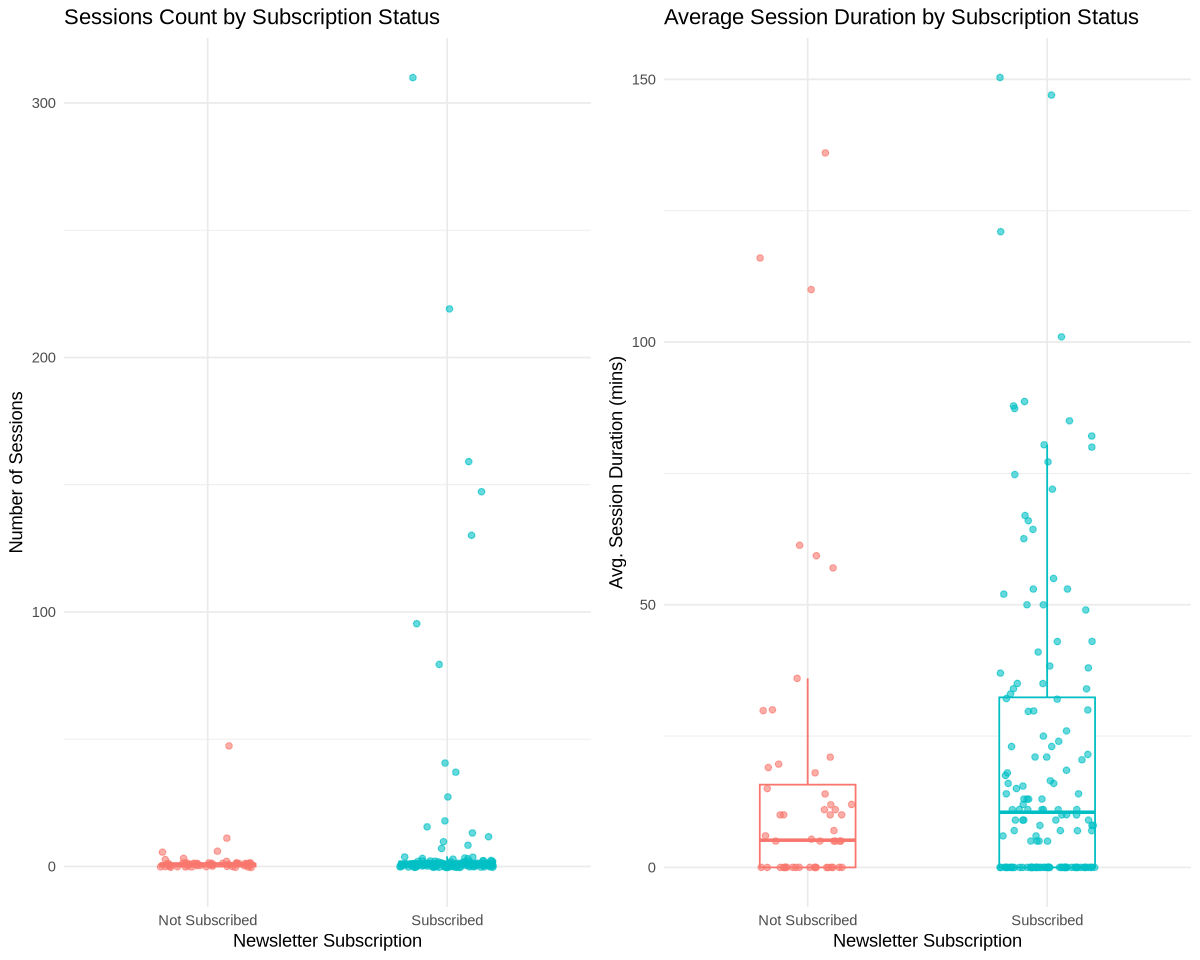

In [59]:
options(repr.plot.width = 10, repr.plot.height = 8)
sessions_count <- ggplot(modeling_data, aes(x = subscribe, y = n_sessions, color = subscribe)) +
  geom_boxplot(width = 0.4, outlier.shape = NA) +
  geom_jitter(alpha = 0.6, width = 0.2) +
  labs(title = "Sessions Count by Subscription Status",
       x = "Newsletter Subscription", y = "Number of Sessions") +
  theme_minimal() +
  theme(legend.position = "none")

Average_session <- ggplot(modeling_data, aes(x = subscribe, y = avg_duration, color = subscribe)) +
  geom_boxplot(width = 0.4, outlier.shape = NA) +
  geom_jitter(alpha = 0.6, width = 0.2) +
  labs(title = "Average Session Duration by Subscription Status",
       x = "Newsletter Subscription", y = "Avg. Session Duration (mins)") +
  theme_minimal() +
  theme(legend.position = "none")
plot_grid(sessions_count, Average_session, ncol = 2)

Subscribers generally show a wider range of session counts. Some highly active players (e.g., >200 sessions) are subscribers, but overlap is substantial, meaning session count alone is not a strong predictor.

Average session duration is similar across both groups. Subscribers include more long-session outliers, but the median duration is similar. This variable shows limited discriminative power.

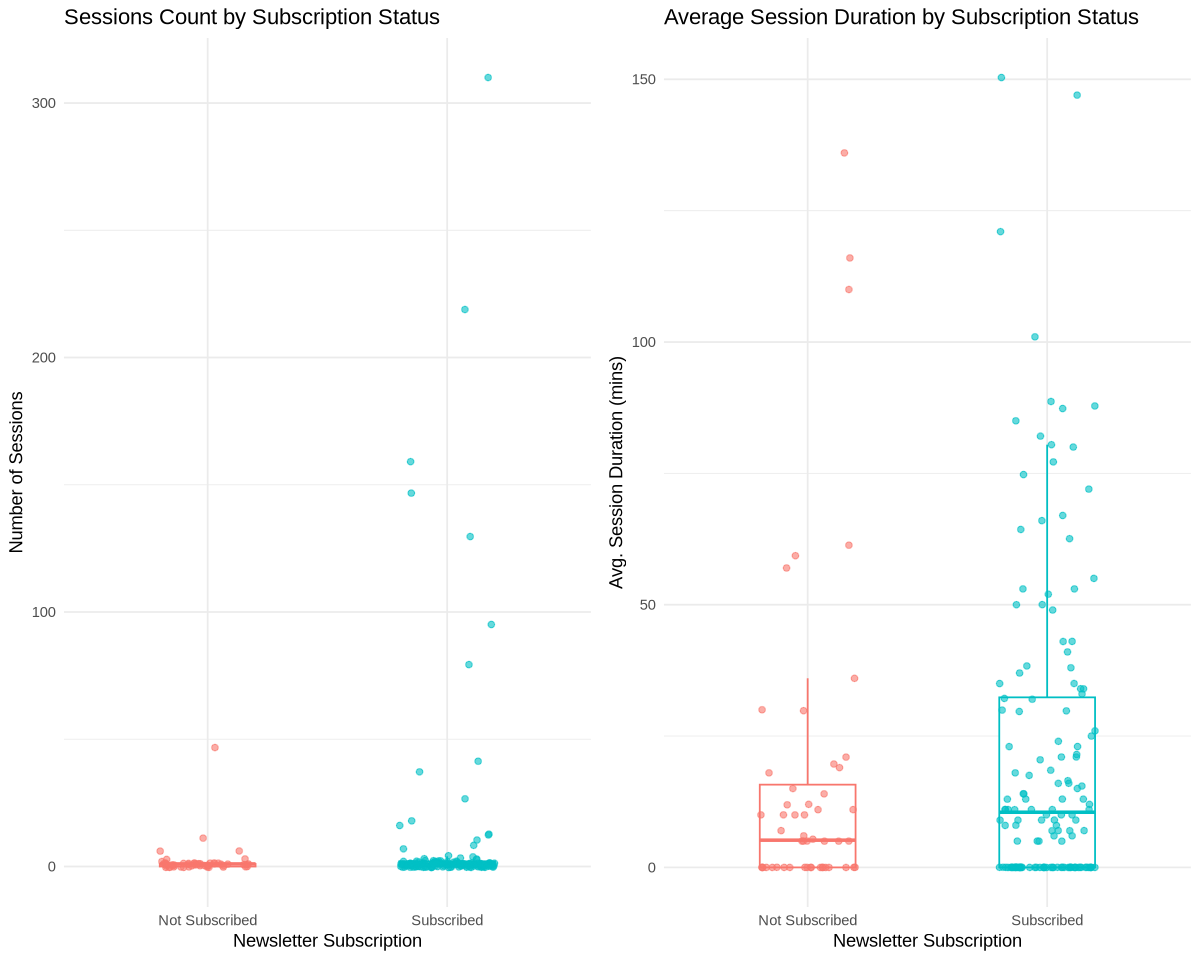

In [60]:
options(repr.plot.width = 10, repr.plot.height = 8)
Night <- ggplot(modeling_data, aes(x = subscribe, y = prop_night, color = subscribe)) +
  geom_boxplot(width = 0.4, outlier.shape = NA) +
  geom_jitter(alpha = 0.6, width = 0.2) +
  labs(title = "Night Sessions Proportion by Subscription Status",
       x = "Newsletter Subscription", y = "Proportion of Sessions at Night") +
  theme_minimal() +
  theme(legend.position = "none")

Weekend <- ggplot(modeling_data, aes(x = subscribe, y = prop_weekend, color = subscribe)) +
  geom_boxplot(width = 0.4, outlier.shape = NA) +
  geom_jitter(alpha = 0.6, width = 0.2) +
  labs(title = "Weekend Sessions Proportion by Subscription Status",
       x = "Newsletter Subscription", y = "Proportion of Sessions on Weekends") +
  theme_minimal() +
  theme(legend.position = "none")
plot_grid(sessions_count, Average_session, ncol = 2)

There is a bimodal distribution—many players either never or always play at night. Subscribers seem more evenly spread, but no clear separation exists. Night activity has high individual variation.

Non-subscribers are clustered around 0% and 100%, indicating polarized weekend play. Subscribers are more diverse, but again, weekend activity alone doesn’t clearly separate the groups.

### Insights Summary:  

-Subscribers had slightly more sessions and higher night/weekend activity on average, but differences were minor.  
-Age: Subscribers were younger (median ~18 vs ~21).  
-Gender: Both groups were mostly male; subscribers had a slightly higher female proportion.  


## Discussion  

The logistic regression model showed limited success in predicting subscription from gameplay behavior alone. Most players—regardless of session pattern or experience—had a high chance of subscribing. Only playtime showed a mild positive relationship with subscription. Age showed the clearest demographic difference: younger players subscribed more often. Gender was similar across groups.

This suggests that behavioral features such as session frequency or time of play are not sufficient to explain subscription behavior. Other factors—like interest in game updates, awareness of the newsletter, or personal habits with email communication—likely play a larger role. From a modeling standpoint, using more expressive models such as decision trees or random forests could potentially capture subtle interactions between features, though my relatively small dataset may limit their effectiveness.

In future work, collecting qualitative data (e.g., survey responses on why players subscribe) or additional behavioral signals (e.g., in-game purchases, social activity) could improve prediction and better inform outreach strategies. Demographic differences, especially age, suggest that tailoring communication style to younger audiences might increase engagement.